In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

!pip install keras

In [0]:
###############################################################################
# Libraries import
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import cv2

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from keras import backend as K
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
K.set_image_dim_ordering('th')
from keras.preprocessing.image import ImageDataGenerator

###############################################################################


In [0]:
# Give a name to id the data used in this training
# use the name of validation driver

# These are the validation divisions created from driver ids:

valid_ids= [['p066', 'p021', 'p024'],
 ['p026', 'p072', 'p015'],
 ['p052', 'p061', 'p042', 'p081'],
 ['p016', 'p041', 'p050'],
 ['p047', 'p064', 'p035'],
 ['p049', 'p002', 'p012', 'p039'],
 ['p056', 'p051', 'p022'],
 ['p075', 'p014', 'p045']]


# Select the validation id group to use for this particular training

i=7
print(valid_ids[i])


# generate file name to identify the valid ids group used

if len(valid_ids[i]) == 3:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                         valid_ids[i][2] + "_1_96_128")
else:
  train_data_filename = str(valid_ids[i][0] + "_" + valid_ids[i][1] + "_" +
                          valid_ids[i][2] + "_" + valid_ids[i][3] + "_1_96_128")
    

print(train_data_filename)

# generate location address for train data
train_file_address =  str("drive/Colab_Notebooks/x_train_" + train_data_filename + ".pk1")
train_file_address2 =  str("drive/Colab_Notebooks/y_train_xy_valid_" + train_data_filename + ".pk1")

print(train_file_address)
print(train_file_address2)


# Create a validation prediction file for dashboard and other visualization 
# Read the original drivers_img_list for validation drivers only
# Short by validation driver in this particular dataset


# Read the full drivers list
train_driver_list = pd.read_csv('drive/Colab_Notebooks/Data/driver_imgs_list.csv')

# filter out only drivers from the validation set
valid_df =train_driver_list.loc[train_driver_list['subject'].isin(valid_ids[i])]



In [0]:
# Import and read data fromm pickle sets
import pickle
with open (train_file_address, 'rb') as f:
    x_train = pickle.load(f)
       
with open (train_file_address2, 'rb') as f:
    y_train = pickle.load(f)
    x_valid = pickle.load(f)
    y_valid = pickle.load(f)

In [0]:
#  Verify data shape
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)


In [0]:
# Define some image and class parameters
# color type: 1 = grey, 3 = rgb
color_type = 1
img_rows, img_cols = 96, 128
nb_classes = 10  # 2 for "imgs_sub2"; 10 for others


input_dim = img_rows * img_cols

print(input_dim)
   
##############################################################################

In [0]:
# reshape images for the Logistic Regression

X_train = x_train.reshape(len(x_train), input_dim) 
X_valid = x_valid.reshape(len(x_valid), input_dim) 
X_train = X_train.astype('float32') 
X_valid = X_valid.astype('float32') 


In [0]:
# Set model batch size and epoch parameters.
batch_size =100
nb_epoch =100


In [0]:
# create a Logistic model with keras

from keras.optimizers import SGD, Adam, Adadelta, Adamax
from keras.regularizers import L1L2

# Key to select if using as-is data(transposed, resize, grey scale) Or
# if using augmented data.  (0 for as-is, 1 for augmented)

augm_data = 0

print(batch_size)


# read saved model, if any
model_from_cache = 0
if model_from_cache == 1:
    model = read_model()
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
else:
    output_dim = nb_classes = 10 
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim, 
                    activation='softmax')) 
    
    adadel = Adadelta(lr=0.59, rho=0.95, epsilon=None, decay=0.0)
    
    sgd = SGD(lr=0.0002, momentum=0.75, decay=0.000001, nesterov=True)
    
    
    # compile and train model
    model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

    if augm_data ==  0:
        # For Non-augmented data
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,
                  verbose=1, validation_data=(X_valid, y_valid))
    else:
    # for augmented data
        history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), 
                            epochs=nb_epoch,
                            verbose=1, steps_per_epoch=len(x_train)/batch_size, 
                            validation_data=(X_valid, y_valid))

model.summary()  # get model summary
 
###############################################################################





train score:  [0.3965403666143594, 0.9545727136431784]
valid score:  [1.6897188686791194, 0.44324772162386084]


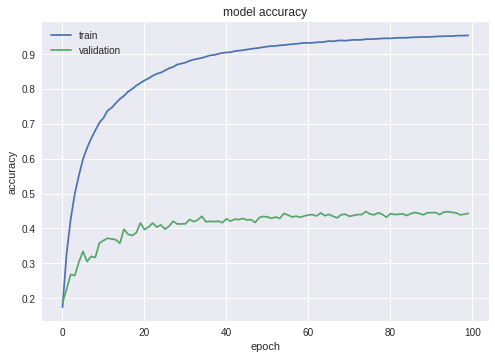

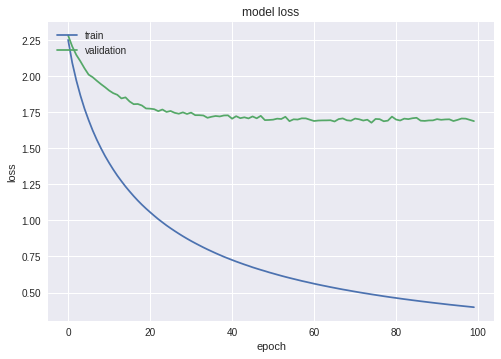

In [62]:
# Score model on train and validation sets.
# Create a dataframe to stroe the results from the training
# Plot training results
train_score = model.evaluate(X_train, y_train, verbose=0)
print('train score: ', train_score)

valid_score = model.evaluate(X_valid, y_valid, verbose=0)
print('valid score: ', valid_score)

train_loss = history.history['loss']
train_acc = history.history['acc']
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']



results_df = pd.DataFrame(
    {'train_loss': train_loss,
     'train_acc': train_acc,
     'val_loss': val_loss,
     'val_acc': val_acc
    })





# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# Print results for inspection

#print(results_df)
print(results_df[:10])
print(results_df[90:100])

In [0]:
# Name the model type to id weights and results
Model_type =  "LR"

In [0]:
# Save weights if model is acceptable

# serialize weights to HDF5
weights_filename = 'drive/Colab_Notebooks/Models/' + Model_type + "_" + train_data_filename + '_weights.h5'
print(str(weights_filename))
model.save_weights(weights_filename)

#model.save_weights(str(train_data_filename +".h5"))
#print("Saved model to disk")

In [0]:
# Save the training results file
results_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_results.csv'
print(results_filename)
results_df.to_csv(results_filename, sep=',')

In [0]:
from skimage.transform import rotate
def show_image(image):
    img = image.squeeze()
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(np.fliplr(rotate(img, 270)), cmap='gray', interpolation='nearest')  
    # Manipulation to display image in the correct orientation!
    plt.show() 
    #print image.shape
    #plt.imshow(image)

In [0]:
# function to convert probs to class
from skimage.transform import rotate

def predictions_results(prediction_probs):
    results = []
    for pred in prediction_probs:
        idx = np.argmax(pred)
        result = np.zeros(len(pred))
        result[idx] = 1
        results.append(result)
    return results


In [0]:
# predict on train set just to verify accuracy
train_predict_probs = model.predict(X_train, batch_size = batch_size, verbose = 1)

# convert prediction probabilities to class array for train set
y_train_predicted= predictions_results(train_predict_probs)


# convert the true and predicted array into classes

# For train data 

train_true_classes = np.argmax(y_train,  axis=1)
train_pred_classes = np.argmax(y_train_predicted,  axis=1)


In [0]:
# Verify predictions for validation set
# collect predictions on valid set
# Store probs in a dataframe and csv for later use
valid_prediction_probs = model.predict(X_valid, batch_size = batch_size, verbose = 1)
print(valid_prediction_probs[1])

valid_probs_df= pd.DataFrame(valid_prediction_probs)
print(valid_probs_df[1:5])
valid_probs_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid_probs.csv'
valid_probs_df.to_csv(valid_probs_filename, sep=',')


# convert prediction probabilities to class array for validation set
y_valid_predicted= predictions_results(valid_prediction_probs)
#print(y_valid_predicted[1])


# convert the true and predicted array into classes
# for validation set

valid_true_classes = np.argmax(y_valid,  axis=1)
valid_pred_classes = np.argmax(y_valid_predicted,  axis=1)


In [0]:
# Add the validation predictions to valid_driver_list
# Add the true classes for now to ensure that the order of valid_driver_list and predictions is same.
#valid_df= pd.DataFrame()
valid_df['true'] = valid_true_classes
valid_df['pred'] = valid_pred_classes
valid_filename = 'drive/Colab_Notebooks/Results/' + Model_type + "_" + train_data_filename + '_valid.csv'
print(valid_filename)
print(valid_df.head(n=5))
valid_df.to_csv(valid_filename, sep=',')



Confusion matrix, without normalization
[[1991   33   13    6    9    4   14    3    9   15]
 [  23 1873   29    3    3    3   29    6    5    3]
 [  34   21 1937    9    2    0   12    5    4    4]
 [  28    8    6 1983   21    4    1    1    0    4]
 [  24   10    8   12 1952    1   12    2    4    8]
 [  22    1    9    6   10 1960    8    1    0    1]
 [  12    9   16    1   10    2 1947    8    9    5]
 [   8    5    9    1    8    1   11 1674   28    5]
 [  30   16   26   23   27    0   13   20 1485   28]
 [  33    6    3   15   11    9    7    8   39 1700]]
Normalized confusion matrix
[[9.49e-01 1.57e-02 6.20e-03 2.86e-03 4.29e-03 1.91e-03 6.68e-03 1.43e-03
  4.29e-03 7.15e-03]
 [1.16e-02 9.47e-01 1.47e-02 1.52e-03 1.52e-03 1.52e-03 1.47e-02 3.03e-03
  2.53e-03 1.52e-03]
 [1.68e-02 1.04e-02 9.55e-01 4.44e-03 9.86e-04 0.00e+00 5.92e-03 2.47e-03
  1.97e-03 1.97e-03]
 [1.36e-02 3.89e-03 2.92e-03 9.64e-01 1.02e-02 1.95e-03 4.86e-04 4.86e-04
  0.00e+00 1.95e-03]
 [1.18e-02 4.92e-03 3

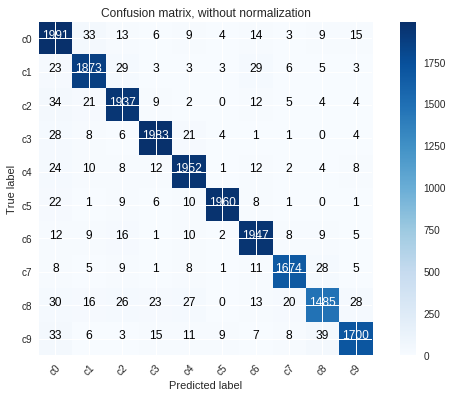

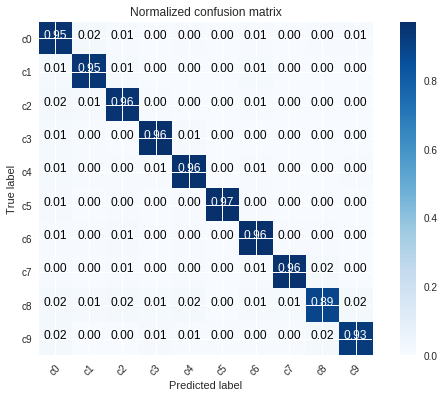

Confusion matrix, without normalization
[[245   7   1   0  51   0   1  62   3  22]
 [  2 164  20   0   2   0   5  58  39   0]
 [  0   0  61   0   4   0  60 156   8   0]
 [  0  37   0   5  14   0   0 162   0  72]
 [  0  11   0   2 136   0   0 113   7  24]
 [  0   1  58   0   0  85   0  58  90   2]
 [  0   3   0   0  22   2 122 150   7   0]
 [  0   0  39   0   0   0   0 193   2  18]
 [  1   7  43   0   0   1  49 127  11   4]
 [ 43   0   0   2  24   0   0 150  16  63]]
Normalized confusion matrix
[[0.62 0.02 0.   0.   0.13 0.   0.   0.16 0.01 0.06]
 [0.01 0.57 0.07 0.   0.01 0.   0.02 0.2  0.13 0.  ]
 [0.   0.   0.21 0.   0.01 0.   0.21 0.54 0.03 0.  ]
 [0.   0.13 0.   0.02 0.05 0.   0.   0.56 0.   0.25]
 [0.   0.04 0.   0.01 0.46 0.   0.   0.39 0.02 0.08]
 [0.   0.   0.2  0.   0.   0.29 0.   0.2  0.31 0.01]
 [0.   0.01 0.   0.   0.07 0.01 0.4  0.49 0.02 0.  ]
 [0.   0.   0.15 0.   0.   0.   0.   0.77 0.01 0.07]
 [0.   0.03 0.18 0.   0.   0.   0.2  0.52 0.05 0.02]
 [0.14 0.   0.   0.01 0.

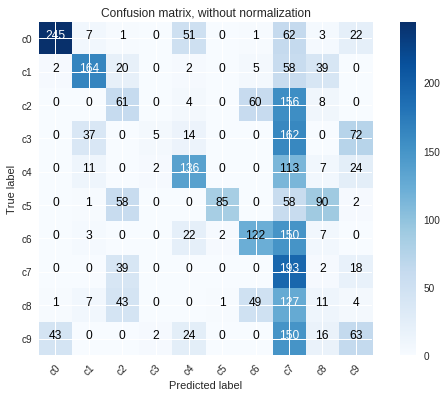

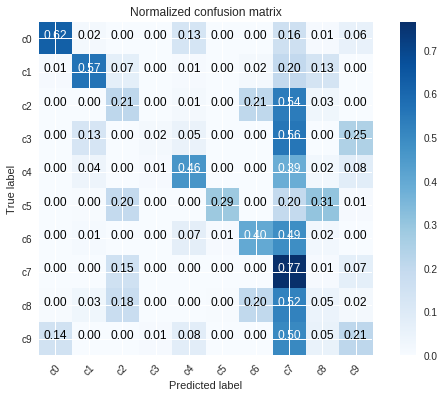

In [54]:
# Results visualization

# Confusion Matrix

class_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
class_names2 = ['c0', 'c1']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
    
# Train data
cnf_matrix = confusion_matrix(train_true_classes, train_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# Valid data

cnf_matrix = confusion_matrix(valid_true_classes, valid_pred_classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

###############################################################################

In [0]:
# Metrics

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(valid_true_classes, valid_pred_classes, average='weighted')


from sklearn.metrics import classification_report
print(classification_report(valid_true_classes, valid_pred_classes, target_names=class_names))


In [0]:
# compare predicts with actual and count correct and incorrect classificaitons
correct_class = []
wrong_class = []
c = 0

for yc, yp in zip(valid_true_classes, valid_pred_classes):
    if yc == yp:
        #print "correct_class: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        correct_class.append([c, yp])
    else:
        #print "wrong_class!: Class {}, {} predicted".format(np.argmax(yclass), np.argmax(ypredict))
        wrong_class.append([c, yp])
    c += 1
    
print("correct_classfully validated {} / {} = {}%".format(len(correct_class), c, (float(len(correct_class))/float(c))*100))
#print "correct_class: {}".format(correct_class)
#print "wrong_class: {}".format(wrong_class)

# Create labels to assign to predictions and plot examples
# labels for org data (use for full data or sub1)
labels_org = [  'c0: safe driving',
            'c1: texting - right',
            'c2: talking on the phone - right',
            'c3: texting - left',
            'c4: talking on the phone - left',
            'c5: operating the radio',
            'c6: drinking',
            'c7: reaching behind',
            'c8: hair and makeup',
            'c9: talking to passenger']

# labels for two category sub2 data
labels_sub2 = [  'c0: safe driving',
            'c1: distracted driving']

# set correct labels
labels=labels_org

    
#print correct_class examples

print("Sample of images validated correctly:")
for s in np.random.choice(len(correct_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[correct_class[s][0]]
    show_image(image)
    print("Classified correctly as {}\n".format(labels[np.argmax(y_valid_predicted[correct_class[s][0]])]))
    
    
# print wrong classification examples    
print("Sample of images validated incorrectly:")
for s in np.random.choice(len(wrong_class), 5, replace = False):
    print("***************\nRendering image {}".format(s))
    image = x_valid[wrong_class[s][0]]
    show_image(image)
    print("Classified incorrectly as {}\n".format(labels[np.argmax(y_valid_predicted[wrong_class[s][0]])]))
    

